In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Package imports

In [2]:
import os, random
import shutil
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import keras
import seaborn as sns
import json
from PIL import Image
import re
import gc

from cv2 import imread, createCLAHE 
from tqdm import tqdm
from tensorflow.keras.applications import ResNet50V2
from keras.preprocessing import image
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import minmax_scale
from sklearn.utils import class_weight

%matplotlib inline

## Helper variables

In [3]:
dataset = '/content/drive/MyDrive/feature_data/'
videos = os.listdir(dataset)
frame_shape = (112, 112)
imgnet_mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")
videos.sort(key=lambda f: int(re.sub('\D', '', f)))
print(videos)

['3', '5', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '27', '28', '30a', '30b', '31', '32', '36c', '36b', '36a', '42', '47', '50', '51', '52', '53', '54', '55', '56', '57', '59', '60', '62', '63', '65', '66', '67b', '67a', '68', '69', '70', '71', '72', '75', '76', '78', '80', '82b', '82a', '83', '84', '85', '87', '88', '89', '90', '92', '93']


## Import Contextual Features

In [5]:
def get_cf(dataset, start, end):
  cf = []
  for v in videos[start: end]:
    c_features = np.load(dataset+v + '/cf/cf.npy')
    cf.extend(c_features)
  return np.array(cf)

In [6]:
def change_shape(root, images, shape=frame_shape):
  res = []
  for i in images:
    im = Image.open(root+i)
    im = im.resize(shape,Image.ANTIALIAS)
    im = np.array(im)
    im = im /255
    res.append(im)
  assert len(res) == len(images)
  return res

## Import Spatial Features

In [7]:
def get_sf(dataset, start, end):
  sf = []
  for v in videos[start: end]:
    print(v)
    names = os.listdir(dataset+v + '/f/')
    try:
      names.remove('.ipynb_checkpoints')
    except:
      pass
    names.sort(key=lambda f: int(re.sub('\D', '', f)))
    imgs_spat = change_shape(dataset+v+'/f/', names)
    sf.extend(imgs_spat)
    gc.collect()
  gc.collect()
  return np.array(sf)

## Import Motion Features

In [8]:
def get_mf(dataset, start, end):
  mf = []
  for v in videos[start: end]:
    print(v)
    names = os.listdir(dataset+v + '/mf/')
    try:
      names.remove('.ipynb_checkpoints')
    except:
      pass
    names.sort(key=lambda f: int(re.sub('\D', '', f)))
    imgs_spat = change_shape(dataset+v+'/mf/', names)
    mf.extend(imgs_spat)
  return np.array(mf)

## Batch Generator Code

In [9]:
class My_Custom_Generator(tf.keras.utils.Sequence) :
  
  def __init__(self, videos, batch_size) :
    self.labels = get_y(get_annotations(), dataset, 0, 16)
    self.cf = get_cf(dataset, 0, 16)
    self.videos = videos  # 1 2 3 folders
    self.YY = []
    for y in self.labels:
      if y == 1:
        self.YY.append([0, 1])
      else:
        self.YY.append([1, 0])

    self.batch_size = batch_size

    # spatial and motion feature meta data
    self.ds = '/content/drive/MyDrive/fd'
    self.mfs = os.listdir(self.ds+'/mf/')
    self.sfs = os.listdir(self.ds+'/f/')
    self.mfs.sort(key=lambda f: int(re.sub('\D', '', f)))
    self.sfs.sort(key=lambda f: int(re.sub('\D', '', f)))
    
    
  def __len__(self) :
    return (np.ceil(len(self.labels) / float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, idx) :
    # extract mf batch
    mfx = []
    for image in self.mfs[idx*self.batch_size: (idx+1)*self.batch_size]:
      im = Image.open(self.ds+'/mf/'+image)
      im = im.resize(frame_shape,Image.ANTIALIAS)
      im = np.array(im)
      im = im / 255
      mfx.append(im)
    mfx = np.array(mfx)

    # extract sf batch
    sfx = []
    for image in self.sfs[idx*self.batch_size: (idx+1)*self.batch_size]:
      im = Image.open(self.ds+'/f/'+image)
      im = im.resize(frame_shape,Image.ANTIALIAS)
      im = np.array(im)
      im = im / 255
      sfx.append(im)
    sfx = np.array(sfx)

    batch_x = [self.cf[idx*self.batch_size: (idx+1)*self.batch_size], sfx, mfx]
    batch_y = self.YY[idx * self.batch_size : (idx+1) * self.batch_size]

    gc.collect()
    return batch_x, np.array(batch_y)

## Preparing ground truth Y

In [10]:
def get_annotations(location = '/content/drive/MyDrive/atm_video_labels.txt'):
  annotation_loc = location
  annotations = {}
  with open(annotation_loc, 'r') as f:
    lines = f.readlines()
    for line in lines:
      line = line.split(' ')
      annotations[line[0][:-4]] = line[1:]
  return annotations

def isinrange(r, fn):
  for i in range(0, len(r), 2):
    if r[i+1][-1] == 'n':
      r[i+1] = r[i+1][:-2]
    if fn >= int(r[i]) and fn <= int(r[i+1]):
      return True
  return False

def get_y(annotations, dataset, start, end):
  Y = []
  for v in videos[start: end]:
    ann = annotations[v][2:]
    fs = os.listdir(dataset+v+ '/f/')
    fs.sort(key=lambda f: int(re.sub('\D', '', f)))
    v_fc = len(fs)
    y = [0] * v_fc
    k = 0
    for i in fs:
      if ann[0] == '-1':
        break
      i = int(i[:-6])
      if isinrange(ann, i):
        y[k] = 1
      k += 1
    Y.extend(y)
  return Y

## Generators to return data in batches while training

In [48]:
tg = My_Custom_Generator(videos, 1)
vg = My_Custom_Generator(videos, 1)

## Preparing ResNet for feature extraction

In [11]:
size = (112, 112, 3)

spatial_feature_extractor = ResNet50V2(input_shape=size , weights = 'imagenet', pooling='avg' , include_top=False)
for layer in spatial_feature_extractor.layers:
	layer.trainable = False

print(spatial_feature_extractor.output)

94683136/94668760 [==============================] - 2s 0us/step
KerasTensor(type_spec=TensorSpec(shape=(None, 2048), dtype=tf.float32, name=None), name='avg_pool/Mean:0', description="created by layer 'avg_pool'")


## Model Architecture

In [12]:
def arch(inputs=size):

  input_spatial = Input(inputs)
  input_motion = Input(inputs)
  input_boo = Input((81))

  x = spatial_feature_extractor(input_spatial)
  y = spatial_feature_extractor(input_motion)


  # x =  GlobalAveragePooling2D()(x)
  # y =  GlobalAveragePooling2D()(y)

  

  conc = concatenate([ input_boo ,x , y])
  print(conc)
  x = Dense(4096 , activation="relu")(conc)
  x = Dropout(0.6, name = "drop2")(x)
  x = Dense( 512 , activation="relu")(x)
  x = Dropout(0.6, name = "drop3")(x)
  x = Dense( 32 , activation="relu")(x)
  x = Dropout(0.6, name = "drop4")(x)
  x = Dense(2 , activation="softmax")(x)

  return Model( inputs = [input_boo , input_spatial , input_motion], outputs = x )


a = arch()

a.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 4177), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(N

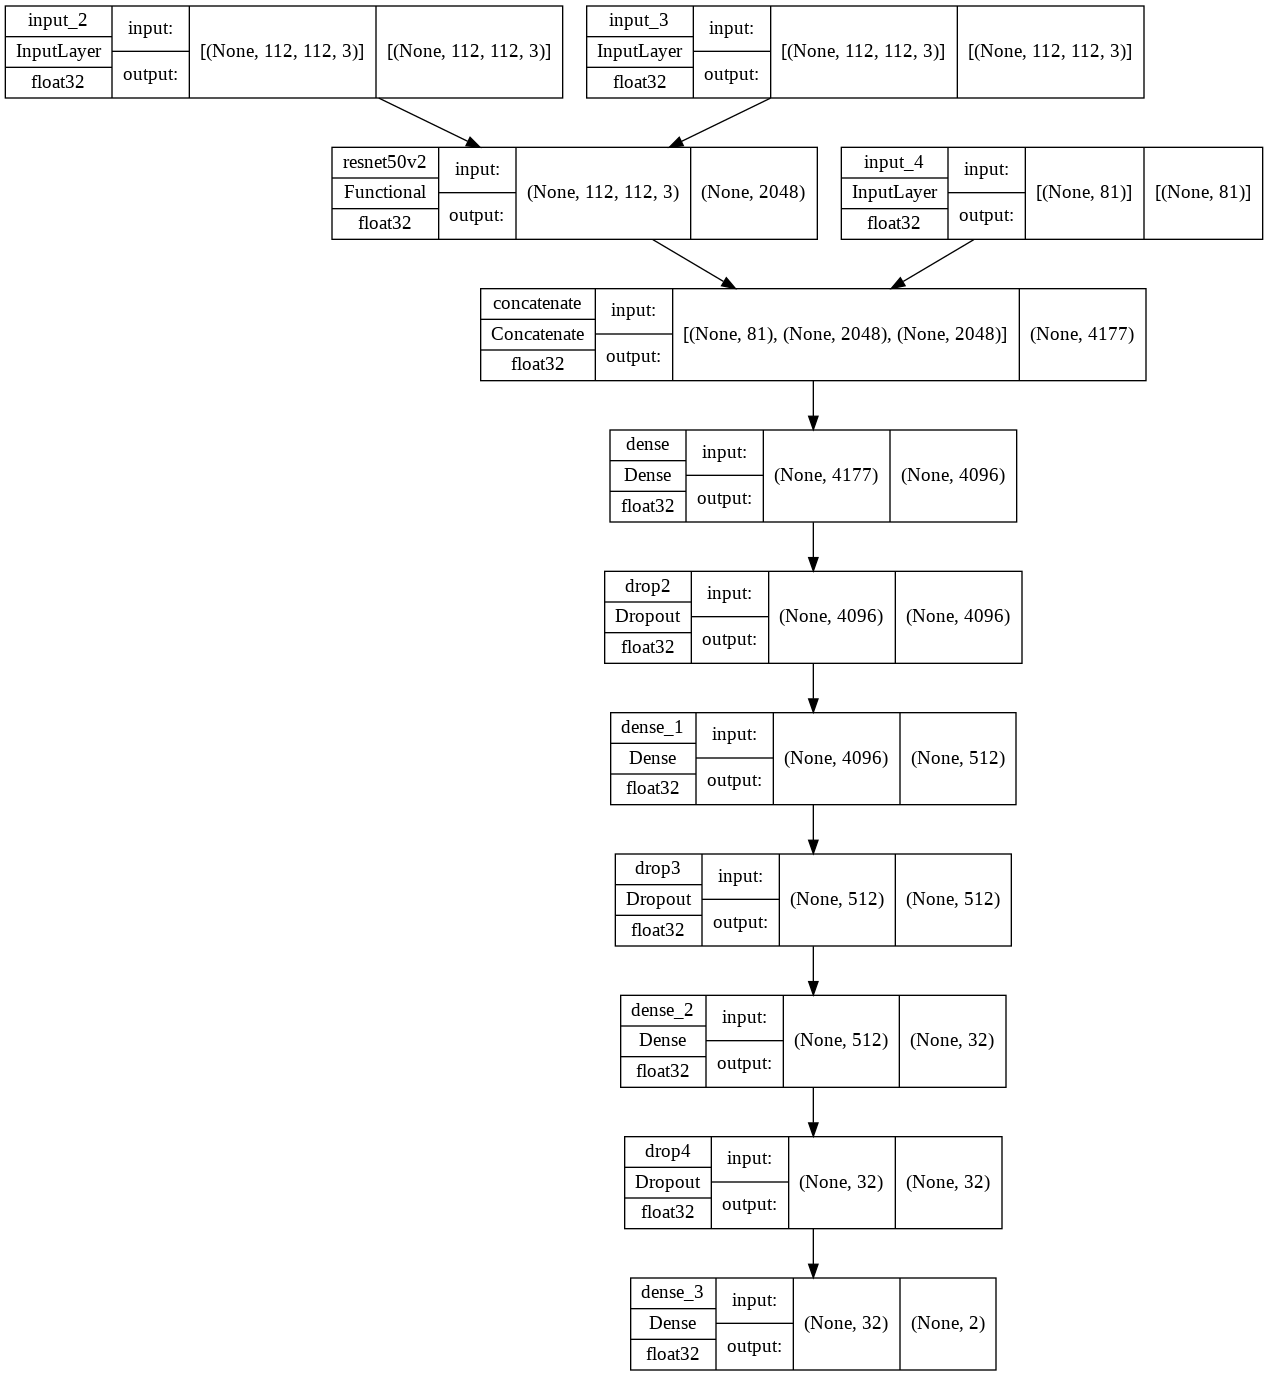

In [13]:
tf.keras.utils.plot_model(
    a,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
)


## Set model loss function, optimizer and training metrics

In [14]:
a.compile(loss ='categorical_crossentropy' , optimizer ='adam' , metrics=['categorical_accuracy'])

## Training the model in batches

In [ ]:
epochs = 10
checkpoint_path = '/content/drive/MyDrive/'
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path+'best_atm_model_112_small_16.h5', save_freq="epoch", save_best_only=True, monitor="loss"),
]
history = a.fit(tg,
                                  epochs=epochs,
                                  callbacks = my_callbacks,
                shuffle = True)

## Model testing and evaluation phase 

In [21]:
lk = ['3', '5', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '27', '28', '30a', '30b', '31', '32', '36c', '36b', '36a', '42', '47', '50', '51', '52', '53', '54', '55', '56', '57', '59', '60', '62', '63', '65', '66', '67b', '67a', '68', '69', '70', '71', '72', '75', '76', '78', '80', '82b', '82a', '83', '84', '85', '87', '88', '89', '90', '92', '93']

vindex = lk.index('21')

vindex_end = lk.index('30a')+1

def moving_average(x, w):
    ret = np.convolve(x, np.ones(w), 'valid') / w
    ret = ret.tolist()
    ret1 = []
    for indi in range(0, w-1):
      ret1.append(x[indi])
    ret1.extend(ret)
    return np.array(ret1)
gc.collect()
cft = get_cf(dataset, vindex, vindex_end)
sft = get_sf(dataset, vindex, vindex_end)
mft = get_mf(dataset, vindex, vindex_end)
yt = get_y(get_annotations(), dataset, vindex, vindex_end)

21
22
23
24
25
27
28
30a
21
22
23
24
25
27
28
30a


In [22]:
print(cft.shape, sft.shape, mft.shape)
new_a = load_model('/content/drive/MyDrive/best_atm_model_112_small_13.h5')

hist = new_a.predict([cft, sft, mft])
print(hist)
print(yt)
print(len(yt))
ytp = hist[:, 1:2]
ytp = np.concatenate(ytp[:], axis=None)

(2559, 81) (2559, 112, 112, 3) (2559, 112, 112, 3)
[[1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 3.0175180e-38]
 [1.0000000e+00 0.0000000e+00]
 ...
 [3.4038783e-07 9.9999964e-01]
 [4.0732360e-08 1.0000000e+00]
 [1.0285932e-12 1.0000000e+00]]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Applying rolling average

In [47]:
ytp = moving_average(ytp, 10)

## Qualitative Results

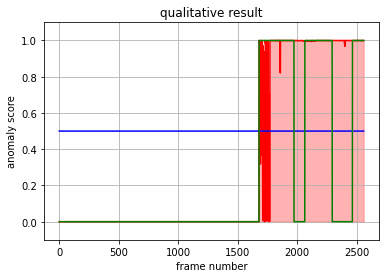

In [23]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(1, cft.shape[0]+1, 1, dtype=int)

ax = plt.gca()
ax.set_ylim([-0.1, 1.1])
ax.set_ylabel('anomaly score')
ax.set_xlabel('frame number')

plt.title("qualitative result")
plt.plot(x, ytp, color="red")

plt.plot(x, [.5]*len(x), color="blue", alpha=1)
plt.plot(x, yt, color="green", alpha=1)
ax.fill_between(x, 0, ytp, color='red', alpha=.3)
plt.grid()
plt.show()

## Quantitative Results

In [24]:
ytg = []
for yy in yt:
  if yy == 1:
    ytg.append([0, 1])
  else:
    ytg.append([1, 0])

ytg = np.array(ytg)

score = new_a.evaluate([cft, sft, mft], ytg)

80/80 [==============================] - 6s 65ms/step - loss: 1.1314 - categorical_accuracy: 0.8835


:::Test Metrics:::

Accuracy:  0.8835482610394686
Precision:  0.6903914590747331
Recall:  0.9402261712439418
f1_score:  0.7961696306429549
False Positive Rate:  0.1345360824742268
ROC AUC:  0.9260513298802525
confusion matrix


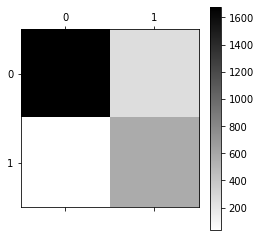

In [25]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

ytpred = []

for ytpr in ytp:
  if ytpr < 0.5:
    ytpred.append(0)
  else:
    ytpred.append(1)

print(':::Test Metrics:::\n')
print('Accuracy: ', accuracy_score(yt, ytpred))
print('Precision: ', precision_score(yt, ytpred))
print('Recall: ', recall_score(yt, ytpred))
print('f1_score: ', f1_score(yt, ytpred))
tn, fp, fn, tp = confusion_matrix(yt, ytpred, labels=[0,1]).ravel()
cm = confusion_matrix(yt, ytpred, labels=[0,1])
print('False Positive Rate: ', fp / (fp + tn))
print('ROC AUC: ', roc_auc_score(yt, ytp))
print('confusion matrix')
plt.matshow(cm, cmap="binary")
plt.colorbar()
plt.show()
